<a href="https://colab.research.google.com/github/Aamaan65/Fault-Detection/blob/main/ML_PBL_Multimodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as IMBPipeline
import tensorflow as tf
from tensorflow import keras

In [ ]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the dataset
file_path = '/content/classData.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
data.head()

First few rows of the dataset:


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


##2.3 Defining electrical faults categories
Here, dependent variable is different types of electrical faults. Combining data from columns 'G', 'C', 'B' and 'A', we define following classes of possible states of electrical transmission lines.

'0000': 'No Fault',

'1000': 'Single Line to Ground A',

'0100': 'Single Line to Ground B',

'0010': 'Single Line to Ground C',

'0011': 'Line-to-Line BC',

'0101': 'Line-to-Line AC',

'1001': 'Line-to-Line AB',

'1010': 'Line-to-Line with Ground AB',

'0101': 'Line-to-Line with Ground AC',

'0110': 'Line-to-Line with Ground BC',

'0111': 'Three-Phase',

'1111': 'Three-Phase with Ground',

'1011': 'Line A Line B to Ground Fault'

In [ ]:
data['Fault_Type'] = data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

# Defining the fault types
fault_types = {
    '0000': 'No Fault',
    '1000': 'Single Line to Ground A',
    '0100': 'Single Line to Ground B',
    '0010': 'Single Line to Ground C',
    '0011': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '1001': 'Line-to-Line AB',
    '1010': 'Line-to-Line with Ground AB',
    '0101': 'Line-to-Line with Ground AC',
    '0110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground',
    '1011': 'Line A Line B to Ground Fault'
}

# Mapping fault type codes to fault type names
data['Fault_Type'] = data['Fault_Type'].map(fault_types)

# Counting the occurrences of each fault type
fault_type_counts = data['Fault_Type'].value_counts()
fault_type_counts

Fault_Type
No Fault                         2365
Line A Line B to Ground Fault    1134
Three-Phase with Ground          1133
Line-to-Line AB                  1129
Three-Phase                      1096
Line-to-Line with Ground BC      1004
Name: count, dtype: int64

In [ ]:
# Descriptive statistics
data.describe()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,0.432006,0.411271,0.555527,0.571429,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515
std,0.495387,0.492095,0.496939,0.494903,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897
min,0.000000,0.000000,0.000000,0.000000,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
25%,0.000000,0.000000,0.000000,0.000000,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977
50%,0.000000,0.000000,1.000000,1.000000,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281
75%,1.000000,1.000000,1.000000,1.000000,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973
max,1.000000,1.000000,1.000000,1.000000,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


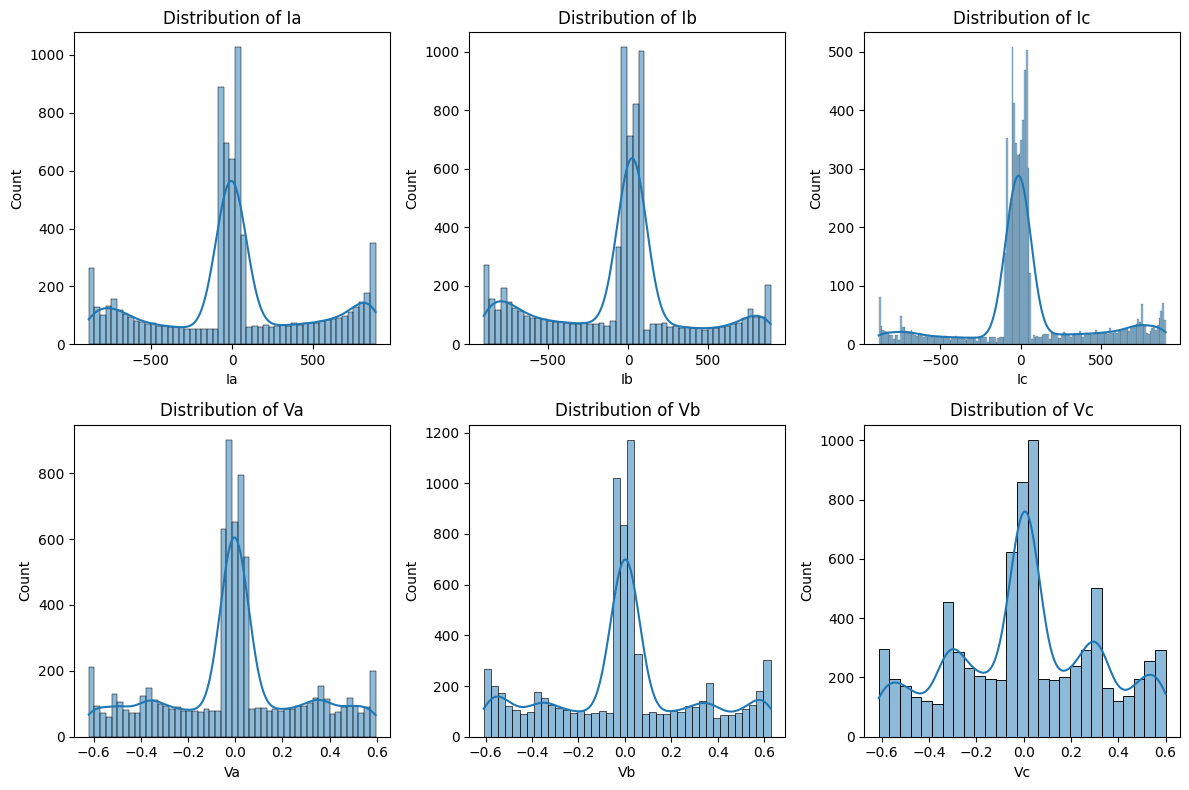

In [ ]:
# Data Visualization: Histograms for each feature
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


Correlation Matrix:
          Ia        Ib        Ic        Va        Vb        Vc
Ia  1.000000 -0.374241 -0.276457  0.035682 -0.274612  0.246043
Ib -0.374241  1.000000 -0.528291  0.029118  0.032101 -0.060023
Ic -0.276457 -0.528291  1.000000 -0.069137 -0.056967  0.122919
Va  0.035682  0.029118 -0.069137  1.000000 -0.480247 -0.450225
Vb -0.274612  0.032101 -0.056967 -0.480247  1.000000 -0.566986
Vc  0.246043 -0.060023  0.122919 -0.450225 -0.566986  1.000000


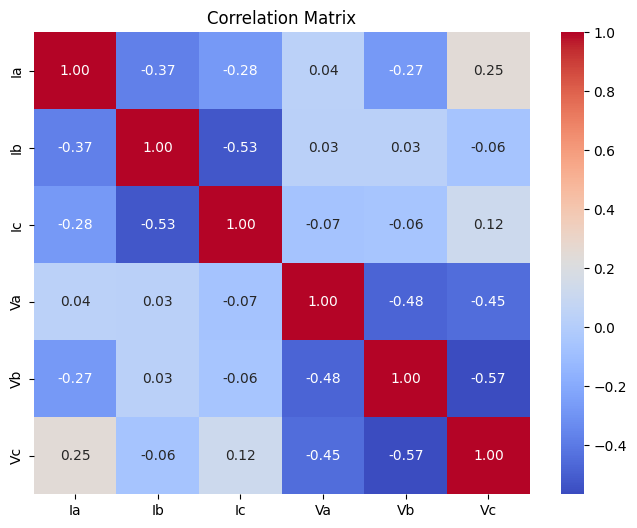

In [ ]:
# Correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = data[features].corr()
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Ia and Ib: Correlation coefficient is -0.374241, indicating a moderate negative correlation. As the current in line A (Ia) increases, the current in line B (Ib) tends to decrease, and vice versa.

Ib and Ic: Correlation coefficient is -0.528291, showing a stronger negative correlation than between Ia and Ib. This suggests that as Ib increases, Ic decreases more consistently.

Va, Vb, and Vc: These voltages show negative correlations with each other (e.g., Va and Vb have a correlation of -0.480247). This might be due to the nature of the electrical system where a rise in voltage in one line could be associated with a drop in another.

Ia and Vc: With a correlation coefficient of 0.246043, there is a weak positive correlation, suggesting that when the current in line A increases, the voltage in line C tends to slightly increase as well.

Ic and Vc: The correlation of 0.122919 is weak, indicating a slight positive relationship between the current in line C and the voltage in line C.

Overall, these correlations can give insights into how current and voltage variables interact in your electrical system, which is crucial for understanding and predicting faults.

In [ ]:
# Normalization (using Min-Max Scaling as an example)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[features])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'Fault_Type' to integer labels
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6288, 6), (1573, 6), (6288,), (1573,))

In [ ]:
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),

    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)

    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")

    # Fit the model on the entire training set
    model.fit(X_train, y_train)
    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

# Train and evaluate each algorithm
models = [
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (CatBoostClassifier(random_state=42, verbose=0), "CatBoost")
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)

Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated
CatBoost: Cross-validation metrics calculated
CatBoost: Test metrics calculated

Cross-validation Metrics:
            Model  Accuracy
0  Decision Trees  0.863392
1   Random Forest  0.859733
2        CatBoost  0.827767

Test Metrics:
            Model  Accuracy
0  Decision Trees  0.886205
1   Random Forest  0.879212
2        CatBoost  0.795931


In [ ]:
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Feature Engineering: Creating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data[features])

# Creating a DataFrame with the new polynomial features
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features))
# Normalization (using Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(poly_features_df)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Display the shapes of the new training and testing sets and the first few rows of the new feature DataFrame
X_train.shape, X_test.shape, y_train.shape, y_test.shape, poly_features_df.head()
features_list = list(poly_features_df.columns)
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Train and evaluate each algorithm
models = [

    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)


Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated

Cross-validation Metrics:
            Model  Accuracy
0  Decision Trees  0.870707
1   Random Forest  0.860210

Test Metrics:
            Model  Accuracy
0  Decision Trees  0.892562
1   Random Forest  0.883026


In [ ]:
# Set random seed
tf.random.set_seed(42)
# Defining neural network model
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(6, activation='softmax')
    ])
    return model

# Initialize Cross-Validation Splitter
num_folds = 5  # You can choose the number of folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize Callbacks
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore best model weights
)

# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by 20% when validation loss plateaus
    patience=5,  # Number of epochs with no improvement before reducing LR
    min_lr=1e-7  # Minimum learning rate
)

# Perform Cross-Validation
all_fold_scores = []

for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(X_scaled, y_encoded)):
    print(f'Fold {fold + 1}/{num_folds}')

    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]

    # Create and compile the model
    model = create_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Multiclass classification
                  metrics=['accuracy'])

    # Train the model with callbacks
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=600, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        verbose=0,
        callbacks=[early_stopping_callback,
                   lr_scheduler
                  ]
    )

    # Evaluate the model on this fold's test data
    fold_test_loss, fold_test_accuracy = model.evaluate(X_test, y_test)
    all_fold_scores.append(fold_test_accuracy)

    # You can also plot training history for each fold if needed

# Calculate and print the cross-validation accuracy
mean_cv_accuracy = sum(all_fold_scores) / num_folds
print(f'Mean Cross-Validation Accuracy: {mean_cv_accuracy * 100:.2f}%')

Fold 1/5
50/50 [==============================] - 0s 3ms/step - loss: 0.2174 - accuracy: 0.8614
Fold 2/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2151 - accuracy: 0.8595
Fold 3/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2253 - accuracy: 0.8582
Fold 4/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2139 - accuracy: 0.8652
Fold 5/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2194 - accuracy: 0.8525
Mean Cross-Validation Accuracy: 85.94%


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

50/50 [==============================] - 0s 2ms/step - loss: 0.2194 - accuracy: 0.8525
Test accuracy: 85.25%


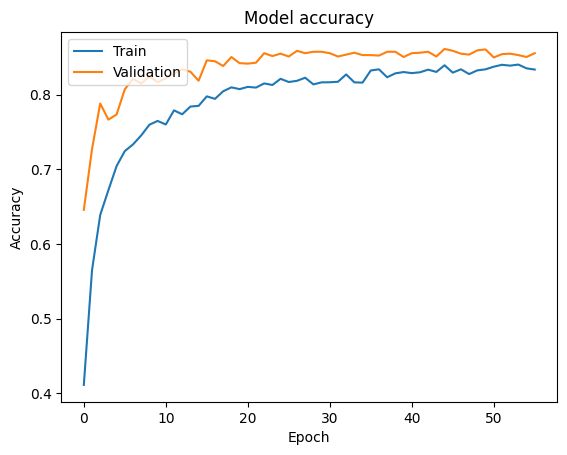

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

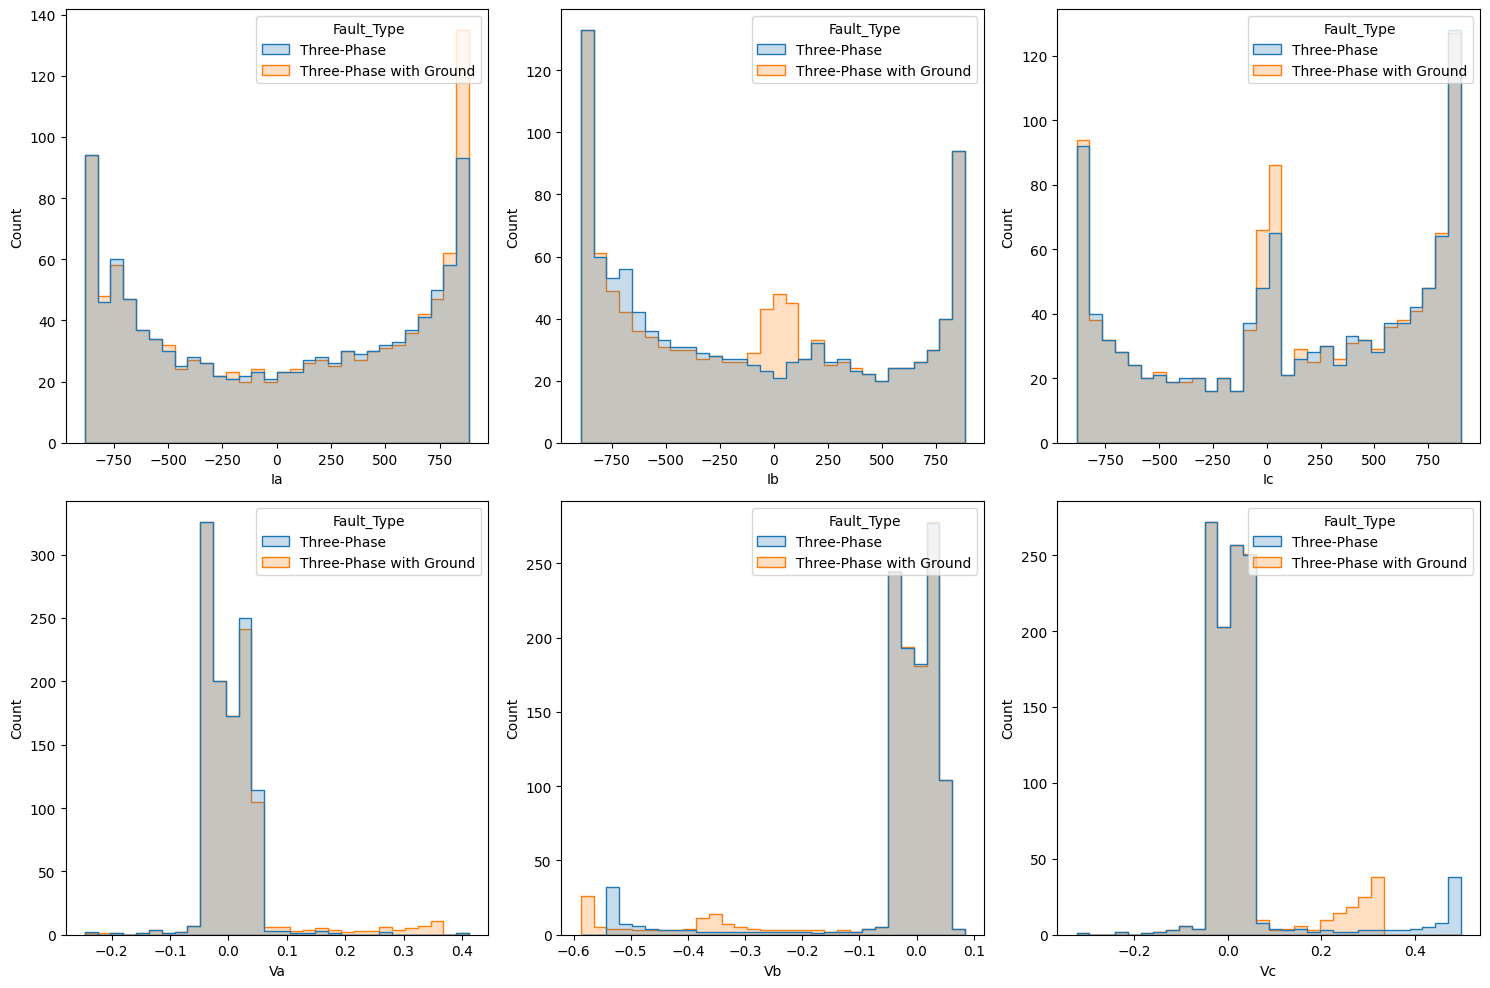

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for only 'Three-Phase Fault' and 'Three-Phase with Ground Fault'
filtered_data = data[data['Fault_Type'].isin(['Three-Phase', 'Three-Phase with Ground'])]

# Features to be plotted
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Plotting histograms for each feature by the two fault types
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=filtered_data, x=feature, hue='Fault_Type', element='step', bins=30)
    #plt.title(f'Distribution of {feature} for Three-Phase Faults')
plt.tight_layout()
plt.show()

In [ ]:
# Adding new features based on domain knowledge

# Zero Sequence Components for Current and Voltage
poly_features_df['ZeroSeqCurrent'] = (poly_features_df['Ia'] + poly_features_df['Ib'] + poly_features_df['Ic']) / 3
poly_features_df['ZeroSeqVoltage'] = (poly_features_df['Va'] + poly_features_df['Vb'] + poly_features_df['Vc']) / 3

# Phase Angle Differences (approximated by product of current and voltage)
poly_features_df['PhaseAngleDiffI'] = poly_features_df['Ia'] * poly_features_df['Ib'] * poly_features_df['Ic']
poly_features_df['PhaseAngleDiffV'] = poly_features_df['Va'] * poly_features_df['Vb'] * poly_features_df['Vc']

# Total Harmonic Distortion (THD) - Approximation
poly_features_df['THD_Ia'] = np.sqrt(poly_features_df['Ia^2'] - poly_features_df['Ia']**2) / poly_features_df['Ia']
poly_features_df['THD_Ib'] = np.sqrt(poly_features_df['Ib^2'] - poly_features_df['Ib']**2) / poly_features_df['Ib']
poly_features_df['THD_Ic'] = np.sqrt(poly_features_df['Ic^2'] - poly_features_df['Ic']**2) / poly_features_df['Ic']

# Voltage and Current Ratios
poly_features_df['V_I_Ratio_A'] = poly_features_df['Va'] / poly_features_df['Ia']
poly_features_df['V_I_Ratio_B'] = poly_features_df['Vb'] / poly_features_df['Ib']
poly_features_df['V_I_Ratio_C'] = poly_features_df['Vc'] / poly_features_df['Ic']

features_list = list(poly_features_df.columns)

# Normalization (using Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(poly_features_df)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Display the shapes of the new training and testing sets and the first few rows of the new feature DataFrame
X_train.shape, X_test.shape, y_train.shape, y_test.shape
poly_features_df.head()

,Ia,Ib,Ic,Va,Vb,Vc,Ia^2,Ia Ib,Ia Ic,Ia Va,...,ZeroSeqCurrent,ZeroSeqVoltage,PhaseAngleDiffI,PhaseAngleDiffV,THD_Ia,THD_Ib,THD_Ic,V_I_Ratio_A,V_I_Ratio_B,V_I_Ratio_C
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,22889.212499,1464.119186,-12980.862053,-60.630172,...,-25.056367,3.333333e-10,1.256217e+05,0.014267,-0.0,-0.0,0.0,-0.002649,0.013737,-0.003121
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,113021.149371,25645.378631,-6161.921773,-105.136155,...,-131.380183,-3.333333e-10,4.700515e+05,0.007311,-0.0,-0.0,0.0,-0.000930,0.001621,-0.010317
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,252899.944252,87829.020905,40696.332111,-133.632598,...,-252.821423,9.251859e-18,-7.107534e+06,0.004599,-0.0,-0.0,-0.0,-0.000528,0.000654,0.001871
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,352766.986396,129303.147985,74178.547188,-139.879576,...,-312.179063,0.000000e+00,-1.614892e+07,0.003227,-0.0,-0.0,-0.0,-0.000397,0.000482,0.001045
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,414302.852236,144283.267892,85145.635467,-134.871266,...,-333.368620,0.000000e+00,-1.908620e+07,0.002282,-0.0,-0.0,-0.0,-0.000326,0.000426,0.000862


In [ ]:
# Define a dictionary to store the cross-validation metrics of the algorithms
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),

    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)

    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")

    # Fit the model on the entire training set
    model.fit(X_train, y_train)

    # Save the fitted model to a pickle file
    model_filename = f'{model_name.replace(" ", "_")}_model.pkl'
    joblib.dump(model, model_filename)
    print(f"{model_name}: Model saved as {model_filename}")

    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

# Train and evaluate each algorithm
models = [
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (CatBoostClassifier(random_state=42, verbose=0), "CatBoost")
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)

Decision Trees: Cross-validation metrics calculated
Decision Trees: Model saved as Decision_Trees_model.pkl
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Model saved as Random_Forest_model.pkl
Random Forest: Test metrics calculated
CatBoost: Cross-validation metrics calculated
CatBoost: Model saved as CatBoost_model.pkl
CatBoost: Test metrics calculated

Cross-validation Metrics:
            Model  Accuracy
0  Decision Trees  0.994911
1   Random Forest  0.998251
2        CatBoost  0.999682

Test Metrics:
            Model  Accuracy
0  Decision Trees  0.996186
1   Random Forest  0.999364
2        CatBoost  1.000000


In [ ]:
import joblib

joblib.dump(models , 'models')

['models']

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ammansharrma","key":"bcd0761b4e78fb89e5be0c84f1ddcd12"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
best_models = {
    "CatBoost": joblib.load('/content/CatBoost_model.pkl'),
    "Decision Trees": joblib.load('/content/Decision_Trees_model.pkl'),
    "Random Forest": joblib.load('/content/Random_Forest_model.pkl'),
}

# Function to evaluate and analyze model performance
def evaluate_and_analyze(model, model_name, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)


# List of class labels (assuming you have them)
class_labels = ["Line A Line B to Ground Fault", "Line-to-Line AB", "Line-to-Line with Ground BC", "No Fault", "Three-Phase", "Three-Phase with Ground"]

# Evaluate and analyze each of the best models
for model_name, model in best_models.items():
    evaluate_and_analyze(model, model_name, X_test, y_test)

Performance Metrics for CatBoost:
Accuracy: 100.00%
Classification Report:
                                precision    recall  f1-score   support

Line A Line B to Ground Fault       1.00      1.00      1.00       227
              Line-to-Line AB       1.00      1.00      1.00       226
  Line-to-Line with Ground BC       1.00      1.00      1.00       201
                     No Fault       1.00      1.00      1.00       473
                  Three-Phase       1.00      1.00      1.00       219
      Three-Phase with Ground       1.00      1.00      1.00       227

                     accuracy                           1.00      1573
                    macro avg       1.00      1.00      1.00      1573
                 weighted avg       1.00      1.00      1.00      1573

Confusion Matrix:
 [[227   0   0   0   0   0]
 [  0 226   0   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 473   0   0]
 [  0   0   0   0 219   0]
 [  0   0   0   0   0 227]]
Performance Metrics for Decis

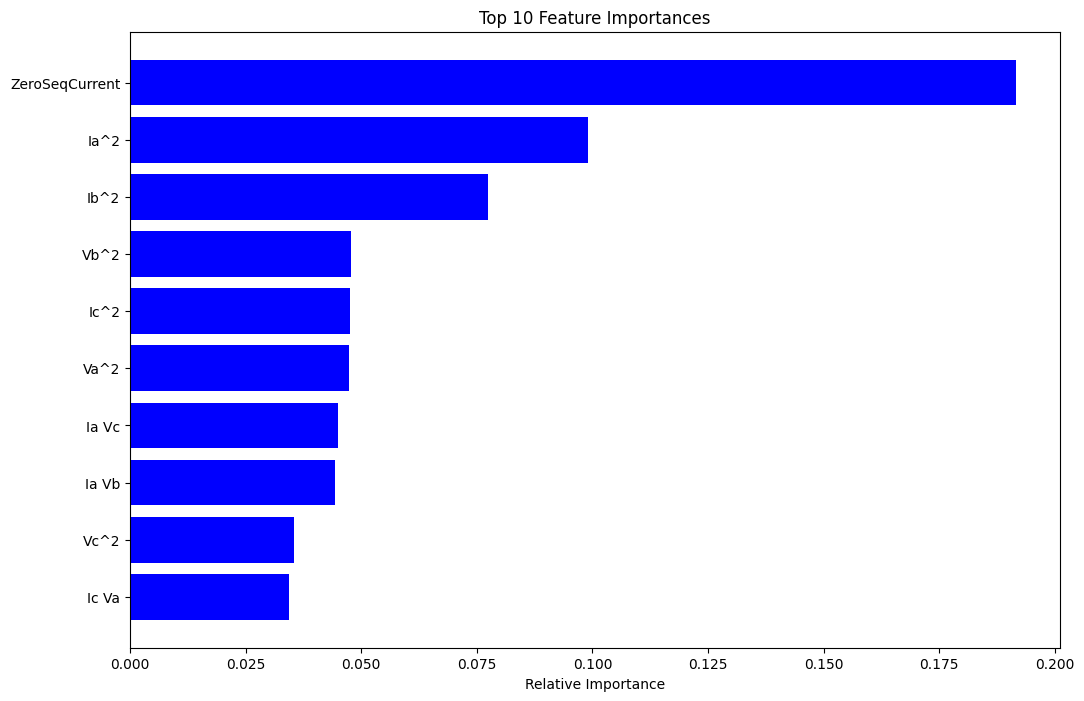

In [ ]:
# Feature Importance Analysis - showing top 10 features
feature_importances = best_models['Random Forest'].feature_importances_

#feature_importances = best_models['CatBoost'].feature_importances_

indices = np.argsort(feature_importances)[-10:]  # Get indices of the top 12 features

plt.figure(figsize=(12, 8))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_list[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

CatBoost accuracy with top 5 features: 0.9981
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       227
           1       1.00      1.00      1.00       226
           2       1.00      1.00      1.00       201
           3       1.00      1.00      1.00       473
           4       1.00      1.00      1.00       219
           5       1.00      1.00      1.00       227

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

[[226   1   0   0   0   0]
 [  1 225   0   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 473   0   0]
 [  0   0   0   0 219   0]
 [  1   0   0   0   0 226]]


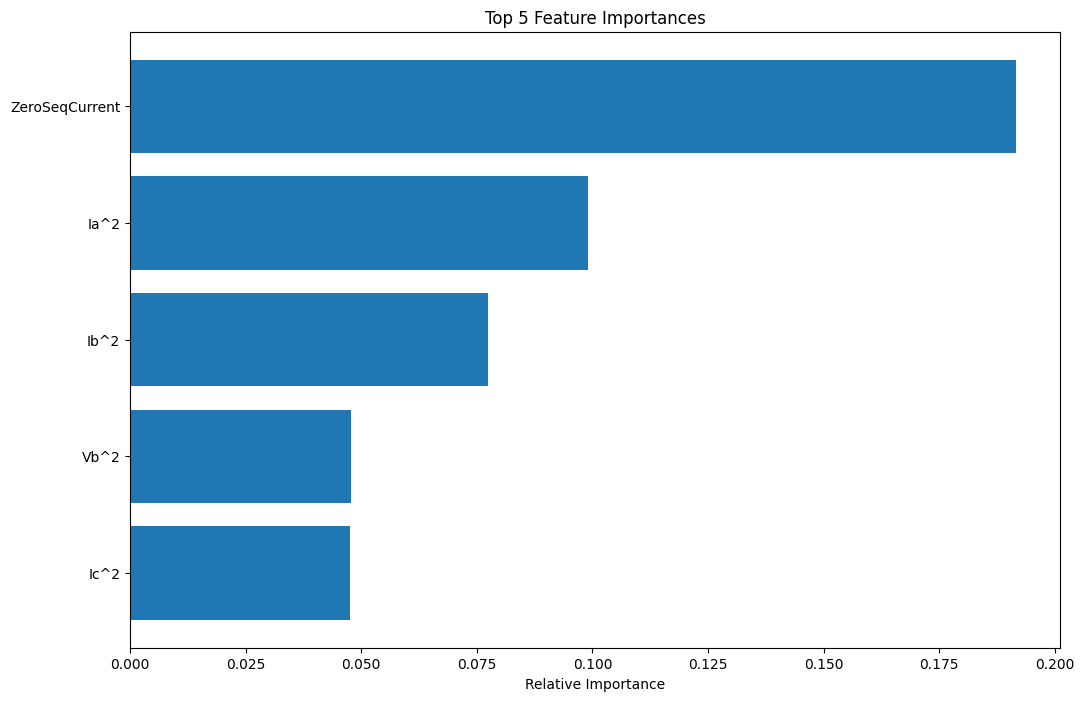

In [ ]:
# Identify the top 10 features from the LightGBM model
feature_importances = best_models['Random Forest'].feature_importances_
indices = np.argsort(feature_importances)[-5:]
top_features = [features_list[i] for i in indices]

# Create a DataFrame with only the top 10 features
top_features_df = poly_features_df[top_features]

# Normalize the top features
scaler = MinMaxScaler()
X_top_scaled = scaler.fit_transform(top_features_df)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(
    X_top_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Initialize the models with only the top 10 features
models_top_features = [
    (CatBoostClassifier(random_state=42, verbose=0), 'CatBoost')
]

# Train and evaluate each model
for model, model_name in models_top_features:
    # Train the model
    model.fit(X_top_train, y_top_train)

    # Save the fitted model
    joblib.dump(model, f'{model_name}_top_features_model.pkl')

    # Predict on the test set
    y_pred = model.predict(X_top_test)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_top_test, y_pred)
    print(f'{model_name} accuracy with top 5 features: {accuracy:.4f}')

    # Optionally, display the classification report and confusion matrix
    print(classification_report(y_top_test, y_pred))
    print(confusion_matrix(y_top_test, y_pred))

# Plot feature importances for visualization
plt.figure(figsize=(12, 8))
plt.title('Top 5 Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), top_features)
plt.xlabel('Relative Importance')
plt.show()